In [37]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

PLOT_WIDTH, PLOT_HEIGHT = 8, 5
COLORS = ["blue", "red", "orange"]

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.insert(0, parent_dir)
import port_management_helper.helper as pmh

spy_returns = pmh.read_excel_default(
    "data/barnstable_analysis_data.xlsx", sheet_name=1
)
spy_returns.fillna(method='ffill', inplace=True)
spy_returns.tail(5)


,SPX,TB1M
date,,
2023-04-28,0.0150,0.0035
2023-05-31,0.0053,0.0041
2023-06-30,0.0670,0.0043
2023-07-31,0.0317,0.0044
2023-08-31,-0.0154,0.0045


In [38]:
spy_excess_returns = (
    spy_returns
    .assign(SPY=lambda df: df["SPY"] - df["TB1M"])
    .drop("TB1M", axis=1)
)
spy_excess_returns.tail(5)

,SPX
date,
2023-04-28,0.0115
2023-05-31,0.0012
2023-06-30,0.0627
2023-07-31,0.0273
2023-08-31,-0.0199


## Shift function
Why do we shift?

For any given date, we can only consider the results until the last period to calculate any metric.

In [39]:
spy_excess_returns_var = spy_excess_returns.copy()
spy_excess_returns_var["SPY Shifted"] = spy_excess_returns_var["SPY"].shift(1)
spy_excess_returns_var

,SPX,SPX Shifted
date,,
1926-01-30,-0.0048,NaN
1926-02-27,-0.0359,-0.0048
1926-03-31,-0.0603,-0.0359
1926-04-30,0.0363,-0.0603
1926-05-28,0.0109,0.0363
...,...,...
2023-04-28,0.0115,0.0336
2023-05-31,0.0012,0.0115
2023-06-30,0.0627,0.0012


## First example: Historical Expanding VaR

In [40]:
spy_excess_returns_var["SPY Historical VaR 5%"] = (
    spy_excess_returns_var["SPY Shifted"].expanding(min_periods=60).quantile(.05)
)
spy_excess_returns_var.iloc[55:65]

,SPX,SPX Shifted,SPX Historical VaR 5%
date,,,
1930-08-29,0.0098,0.0376,NaN
1930-09-30,-0.1247,0.0098,NaN
1930-10-31,-0.0851,-0.1247,NaN
1930-11-29,-0.0210,-0.0851,NaN
1930-12-31,-0.0723,-0.0210,NaN
1931-01-31,0.0585,-0.0723,-0.1249
1931-02-28,0.1097,0.0585,-0.1247
1931-03-31,-0.0697,0.1097,-0.1227
1931-04-30,-0.0936,-0.0697,-0.1208


The VaR for a certain period includes data up until the period before.

For instance, when we get the VaR for "1931-01-31", we use data until "1930-12-31".

## How good is my VaR?
Compare the VaR for that date with the actual return.

What is the percentage of periods in which the returns are lower than the VaR?

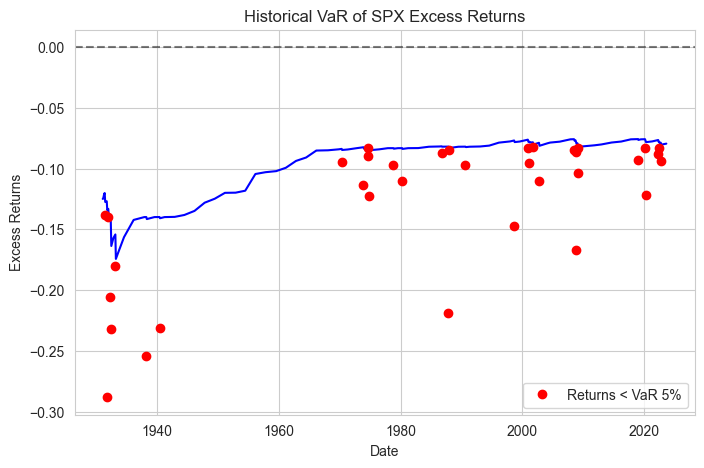

In [52]:
plt.figure(figsize=(PLOT_WIDTH, PLOT_HEIGHT))
plt.axhline(y=0, linestyle='--', color='black', alpha=0.5)
plt.plot(
    spy_excess_returns_var.dropna().index,
    spy_excess_returns_var["SPY Historical VaR 5%"].dropna(),
    color=COLORS[0]
)
spy_excess_returns_surpass_var = (
    spy_excess_returns_var
    .dropna()
    .loc[lambda df: df["SPY"] < df["SPY Historical VaR 5%"]]
)
plt.plot(
    spy_excess_returns_surpass_var.index,
    spy_excess_returns_surpass_var["SPY"],
    linestyle="",
    marker="o",
    color=COLORS[1],
    label="Returns < VaR 5%"
)
plt.title("Historical VaR of SPY Excess Returns")
plt.xlabel("Date")
plt.ylabel("Excess Returns")
plt.legend()
plt.show()

In [58]:
spy_excess_returns_var_analysis = (
    spy_excess_returns_var
    .dropna()
    .assign(smaller=lambda df: df["SPY"] < df["SPY Historical VaR 5%"])
    .rename({"smaller": "Return < VaR 5%"}, axis=1)
)
spy_excess_returns_var_analysis

,SPX,SPX Shifted,SPX Historical VaR 5%,Return < VaR 5%
date,,,,
1931-01-31,0.0585,-0.0723,-0.1249,False
1931-02-28,0.1097,0.0585,-0.1247,False
1931-03-31,-0.0697,0.1097,-0.1227,False
1931-04-30,-0.0936,-0.0697,-0.1208,False
1931-05-29,-0.1381,-0.0936,-0.1201,True
...,...,...,...,...
2023-04-28,0.0115,0.0336,-0.0797,False
2023-05-31,0.0012,0.0115,-0.0796,False
2023-06-30,0.0627,0.0012,-0.0796,False


In [70]:
(
    spy_excess_returns_var_analysis
    .groupby("Return < VaR 5%")
    ["Return < VaR 5%"]
    .agg(["count"])
    .assign(percentage=lambda df: df['count'] / df['count'].sum(axis=0))
    .rename(columns=lambda c: c.title())
)

,Count,Percentage
Return < VaR 5%,,
False,1077,0.9685
True,35,0.0315


How good is my VaR?

Not very good... it overestimates the tail risk of my asset.

## Hit Ratio

$$
\text{Hit Ratio} = \frac{n (\\ R_t < \text{VaR}(q)_t)}{n}
$$

## Hit Ratio Error

$$
\text{Hit Ratio Error} = \left| \frac{\text{Hit Ratio}}{q} - 1 \right|
$$

$q$ is always your target Hit Ratio.

You are not paid to be over cautious!

## Our goal
Find a VaR estimate which in the out-of-sample has the smallest hit ratio.

## What changes in other VaR estimates?

The way (the function) I define the VaR for each period.

In [72]:
spy_excess_returns_var["SPY Historical VaR 5%"] = (
    spy_excess_returns_var["SPY Shifted"].expanding(min_periods=60).quantile(.05)
)
spy_excess_returns_var.tail(3)

,SPX,SPX Shifted,SPX Historical VaR 5%
date,,,
2023-06-30,0.0627,0.0012,-0.0796
2023-07-31,0.0273,0.0627,-0.0795
2023-08-31,-0.0199,0.0273,-0.0794


In [ ]:
def my_personal_var(return_series: pd.Series, percentile) -> pd.Series:
    return return_series.expanding(min_periods=60).quantile(percentile)

In [73]:
def historical_rolling_var(return_series: pd.Series, percentile) -> pd.Series:
    return return_series.rolling(window=60).quantile(percentile)

In [98]:
def var_calculator(excess_returns, var_func, var_name, percentile):
    excess_returns = excess_returns.copy()
    excess_returns["SPY Shifted"] = excess_returns["SPY"].shift()
    excess_returns[var_name] = var_func(excess_returns["SPY Shifted"], percentile)
    excess_returns = excess_returns.dropna(axis=0)

    plt.figure(figsize=(PLOT_WIDTH, PLOT_HEIGHT))
    plt.axhline(y=0, linestyle='--', color='black', alpha=0.5)
    plt.plot(
        excess_returns.dropna().index,
        excess_returns[var_name].dropna(),
        color=COLORS[0],
        label=var_name
    )
    plt.plot(
        excess_returns.dropna().index,
        excess_returns["SPY"].dropna(),
        color=COLORS[2],
        label="SPY Returns",
        alpha=.2
    )
    excess_returns_surpass_var = (
        excess_returns
        .dropna()
        .loc[lambda df: df["SPY"] < df[var_name]]
    )
    plt.plot(
        excess_returns_surpass_var.index,
        excess_returns_surpass_var["SPY"],
        linestyle="",
        marker="o",
        color=COLORS[1],
        label=f"Return < {var_name}"
    )
    plt.ylim(min(excess_returns["SPY"]), .01)
    hit_ratio = len(excess_returns_surpass_var.index) / len(excess_returns.index)
    hit_ratio_error = abs((hit_ratio / percentile) - 1)
    plt.title(f"{var_name} of SPY Excess Returns")
    plt.xlabel(
        f"Hit Ratio: {hit_ratio:.2%}; Hit Ratio Error: {hit_ratio_error:.2%}"
    )
    plt.ylabel("Excess Returns")
    plt.legend()
    plt.show()

## Rolling Historical VaR

Given a rolling window size $r$:

$$
\text{VaR}(q)_t = p^q \left[ r_{t-r}, \\ r_{t-(r-1)}, \\ r_{t-(r-2)}, \\ \dots, \\ r_{t-1}\right]
$$

## Rolling vs Expanding
- Does not consider considerably old data which might be prior to a structural change.
- Has a hard threshold of which data is important and which is not: big weight on $r$.

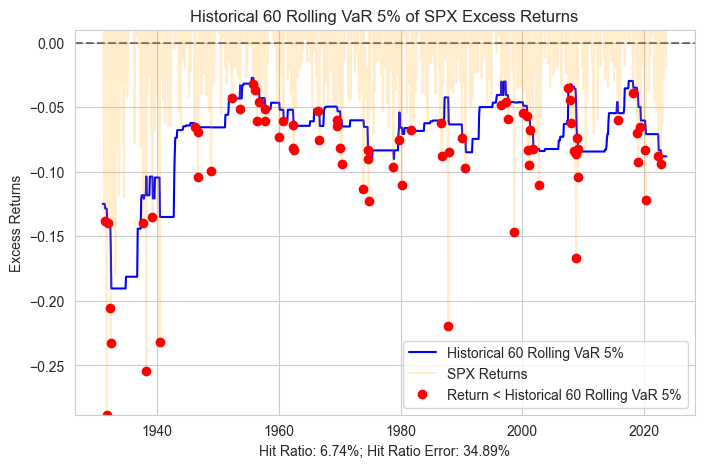

In [100]:
def historical_rolling_var(return_series: pd.Series, percentile) -> pd.Series:
    return return_series.rolling(window=60).quantile(percentile)

var_calculator(spy_excess_returns, historical_rolling_var, "Historical 60 Rolling VaR 5%", .05)

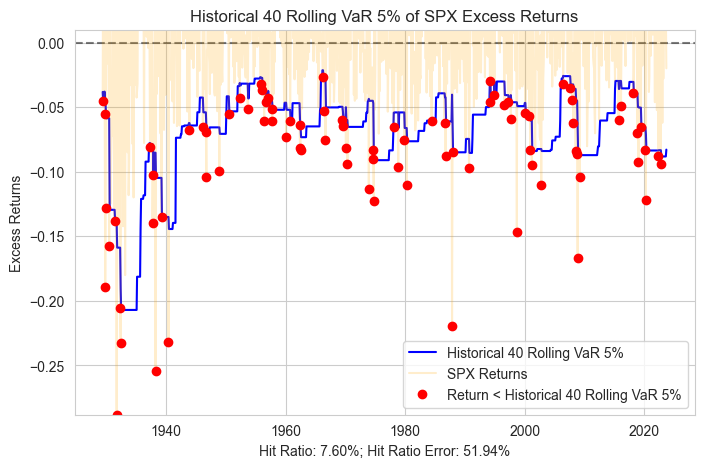

In [102]:
def historical_rolling_var(return_series: pd.Series, percentile) -> pd.Series:
    return return_series.rolling(window=40).quantile(percentile)

var_calculator(spy_excess_returns, historical_rolling_var, "Historical 40 Rolling VaR 5%", .05)

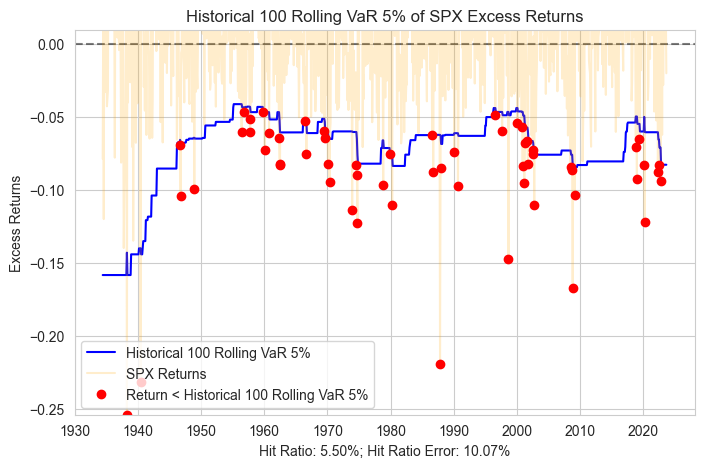

In [104]:
def historical_rolling_var(return_series: pd.Series, percentile) -> pd.Series:
    return return_series.rolling(window=100).quantile(percentile)

var_calculator(spy_excess_returns, historical_rolling_var, "Historical 100 Rolling VaR 5%", .05)